Hi! This is a pytorch classification example built with inspiration from https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [1]:
### PYTORCH CLASSIFICATION EXAMPLE
# 
# Author: Rasmus F. Ørsøe
# email: pcs557@alumni.ku.dk
#

import pandas as pd
import numpy as np
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy.special import expit

# Load 2nd version of the Aleph Data. Why not the first?
path = 'AlephBtag_MC_small_v2.csv'
data = pd.DataFrame(np.genfromtxt(path, names=True))
variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


Remember: 'isb' is our binary truth. If isb = 1 then it's a b-quark and isb = 0 if it is not. Because this is our truth, we must not include it as the input to our model. Also, 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against. Therefore 'nnbjet' shouldn't be in our input either. Usually one would apply regularization/standardization of data at this step - but lets skip this for now and just move onto seperate the data into input, truth and benchmark:

In [2]:
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb')]
input_data      = data[input_variables]
truth           = data['isb']
benchmark       = data['nnbjet']
print(input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')


Let us now divide the truth and input_data into two parts; a training sample and a validation sample:

In [3]:
input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth, test_size=0.25, random_state=42)

Before we go any further, we need to put this data into the pytorch-Dataset class, such that we can extract it during training. This is a little annoying, but it's worth the effort.

In [4]:
## train data
class MyDataset(Dataset):    
    def __init__(self, X_data, y_data):
        self.input = X_data
        self.truth = y_data
        
    def __getitem__(self, index):
        return self.input[index], self.truth[index]
        
    def __len__ (self):
        return len(self.input)


train_data = MyDataset(torch.FloatTensor(np.array(input_train)), 
                       torch.FloatTensor(np.array(truth_train)))
valid_data = MyDataset(torch.FloatTensor(np.array(input_valid)), 
                       torch.FloatTensor(np.array(truth_valid)))

## We can now access input_train via train_data.input and truth_train via train_data.truth, and similarly for input_valid and truth_valid.
print(train_data.input)
print(train_data.truth)

tensor([[ 3.5892e+01,  6.2160e-01,  6.8090e-01,  ...,  5.5970e-01,
          7.5530e-01, -3.0000e-04],
        [ 4.0348e+01, -5.0370e-01,  6.2080e-01,  ...,  2.2580e-01,
          2.0600e-02, -3.0000e-04],
        [ 5.0639e+01,  1.9310e-01,  2.8763e+00,  ...,  2.5530e-01,
          4.5800e-02, -3.0000e-04],
        ...,
        [ 4.4190e+01,  7.6860e-01, -6.5920e-01,  ...,  3.5270e-01,
          5.6000e-03, -3.0000e-04],
        [ 4.2710e+01, -2.7400e-02,  3.3280e-01,  ...,  2.6690e-01,
          4.5620e-01,  3.7260e-01],
        [ 4.8249e+01,  3.1340e-01,  1.5721e+00,  ...,  2.5850e-01,
          1.5900e-02, -3.0000e-04]])
tensor([1., 0., 0.,  ..., 0., 1., 0.])


Let us now define the pytorch model:

In [5]:
class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()        # Here we define the layers
        self.input_layer = nn.Linear(9, 24) 
        self.hidden_layer1 = nn.Linear(24, 24)
        self.hidden_layer2 = nn.Linear(24, 12)
        self.output_layer = nn.Linear(12, 2) 
        self.relu = nn.ReLU()
        
    def forward(self, inputs):                           # Here we define how data passes through the layers. 
        x = self.input_layer(inputs)
        x = self.relu(x)
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x =  self.hidden_layer2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

   

Now we need to write our training loop! 

In [6]:

def Train(model,optimizer, loss_function, train_loader,validation_loader, device, epochs):
    validation_loss = []
    training_loss   = []
    model.train()
    for e in range(0, epochs):
        epoch_loss = 0
        n_minibatches = 0
        for input_train_batch, truth_train_batch in train_loader:
            input_train_batch, truth_train_batch = input_train_batch.to(device), truth_train_batch.to(device)
            optimizer.zero_grad()
            prediction = model(input_train_batch)   # this asks our model to produce predictions on the training batch
            
            loss = loss_function(prediction, truth_train_batch.long()) # this calculates the loss

            loss.backward()                              # This initiates the backpropagation
            optimizer.step()

            epoch_loss += loss.item()
            n_minibatches += 1
        
        valid_loss = Validate(model, validation_loader, device, loss_function)   # Now that the model have trained 1 epoch, we evaluate the model on the validation set!
        validation_loss.append(valid_loss)
        training_loss.append(epoch_loss/n_minibatches)
        print('EPOCH: %s | training loss: %s  | validation loss: %s'%(e+1,round(epoch_loss/n_minibatches,3), round(valid_loss, 3)))
    return training_loss, validation_loss

def Validate(model, validation_loader, device, loss_function):
    model.eval()
    n_batches  = 0
    validation_loss = 0
    with torch.no_grad():
        for input_valid_batch, truth_valid_batch in validation_loader:
            input_valid_batch, truth_valid_batch = input_valid_batch.to(device), truth_valid_batch.to(device)
            prediction = model(input_valid_batch)
            loss = loss_function(prediction, truth_valid_batch.long())
            validation_loss += loss.item()
            n_batches += 1
    validation_loss = validation_loss/n_batches
    return validation_loss

def Predict(model, prediction_loader, device):
    model.eval()
    predictions = []
    print('PREDICTING!')
    with torch.no_grad():
        for input_pred_batch, _ in validation_loader:
            input_pred_batch = input_pred_batch.to(device)
            prediction = model(input_pred_batch)
            predictions.extend(prediction.numpy())
    print('Done Predicting!')
    return predictions
            
            
    

learning_rate = 1e-3
batch_size    = 32
n_epochs      = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OurModel() 
model.to(device)  ## mounts the model to the selected device. Either cpu or a GPU.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=valid_data, batch_size=batch_size)

training_loss, validation_loss = Train(model, optimizer, loss_function, train_loader, validation_loader, device, n_epochs)
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, 
## namely input_valid and truth_valid.


EPOCH: 1 | training loss: 0.479  | validation loss: 0.303
EPOCH: 2 | training loss: 0.294  | validation loss: 0.27
EPOCH: 3 | training loss: 0.275  | validation loss: 0.308
EPOCH: 4 | training loss: 0.271  | validation loss: 0.261
EPOCH: 5 | training loss: 0.267  | validation loss: 0.297
EPOCH: 6 | training loss: 0.268  | validation loss: 0.265
EPOCH: 7 | training loss: 0.268  | validation loss: 0.259
EPOCH: 8 | training loss: 0.268  | validation loss: 0.272
EPOCH: 9 | training loss: 0.266  | validation loss: 0.258
EPOCH: 10 | training loss: 0.267  | validation loss: 0.265


We can now extract information from the training and validation by accessing training_loss and validation_loss :

(array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 7 Text yticklabel objects>)

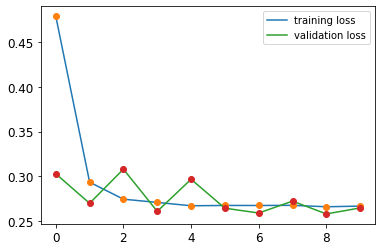

In [7]:

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)

As you can see, after 8th epoch the validation loss and training loss cross each other. This is important! Do you know why? Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!

In [8]:
predictions = Predict(model,validation_loader,device) # this asks the trained model to make predictions on input_valid. Notice we're not giving it any truth values!

### This bit of gymnastics is because the output of our model is raw logits from the final output layer.
# This means it produces a pseudo score for each class (a score for 0 and a score for 1). 
# expit converts this logit to a number in [0,1]
# We then combine the scores such that our_score = (1-score)/(1-score + 0-score)
predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
predictions['not_bquark'] = expit(predictions['not_bquark'])
predictions['bquark'] = expit(predictions['bquark'])

predictions = predictions['bquark']/(predictions['bquark'] + predictions['not_bquark'])


PREDICTING!
Done Predicting!


We can now evaluate our predictions by producing a ROC-curve and calculating the AUC-score and comparing it to our 'nnbjet' competitor. You can read more about ROC curves and AUC scores in 
https://mlwhiz.com/blog/2021/02/03/roc-auc-curves-explained/ (and by attending Troel's lectures!)

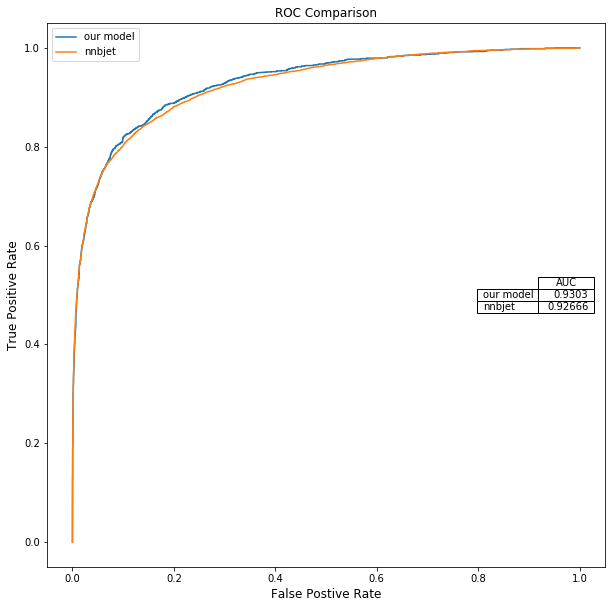

In [9]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)  ## this calculates the false positive rate and the true positive rate for our model's predictions on the validation sample
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth,benchmark) ## this calculates the false positive rate and the true postive rate for nnbjet on the entire data sample

### We can npw calculate the AUC scores of these ROC-curves
auc_score = auc(fpr,tpr)                      # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)# this is the auc score for nnbjet


### Let's plot the results

fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 12)
plt.plot(fpr,tpr, label = 'our model')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = 'nnbjet')
plt.legend()
plt.xlabel('False Postive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)
### This just plots a table with the AUC-scores.
row_labels=['our model',
            'nnbjet']
table_vals=[[round(auc_score,5)],
            [round(auc_score_nnbjet,5)]]
col_labels=['AUC']
the_table = plt.table(cellText=table_vals,
                  colWidths = [0.1]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')
########



So our __very__ simple and un-optimized model achieves a wee bit higher AUC score than nnbjet. (higher is better). Can you beat this? 